### `CNNs for Text Classification`
* This Notebook will discuss how convolutional neural networks can be used to find general patterns in text and perform text classification.
* The end of this Notebook specifically addresses training a CNN to classify the sentiment (positive or negative) of movie reviews.

![cnn](https://cezannec.github.io/assets/cnn_text/conv_maxpooling_steps.gif)

![img.png](https://cezannec.github.io/assets/cnn_text/conv_dimensions.png)

![img2.png](https://cezannec.github.io/assets/cnn_text/similar_phrases_conv_out.png)

![img3.png](https://cezannec.github.io/assets/cnn_text/maxpooling_over_time.png)

![img4.png](https://cezannec.github.io/assets/cnn_text/complete_text_classification_CNN.png)

----

In [1]:
# Install some dependencies
!pip install -q pydot graphviz tqdm spacy termcolor
!pip install -q -U pip setuptools wheel
!pip install -q -U spacy
!python -q -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 30.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


* `Import Libraries`

In [2]:
import numpy as np
import pandas as pd
import random
from collections import Counter
from termcolor import colored
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import spacy

# sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder

# tensorflow
import tensorflow as tf

* `Load the Dataset`

In [3]:
# Load dataset
data = fetch_20newsgroups(subset='test', remove=['headers', 'footers', 'quotes'],
                         categories=['rec.autos', 'comp.windows.x',
                                     'soc.religion.christian', 'rec.sport.baseball'])

# Split to X & y
X = data.data
y = [data.target_names[i] for i in data.target]

# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [4]:
# Load the GloVe model from spacy
nlp = spacy.load('en_core_web_md')

In [5]:
# Get the longest length text in X
longest_input = max(len(doc.split()) for doc in X_train)
longest_input # too much, I will truncate instead

8535

In [6]:
# truncation to make max tokens in each doc (first 500) with each token embedding of size 300
MAX_TOKENS = 500
EMBED_SIZE = 300

In [7]:
# Embeddings for training data (3D matrix) as I want to incoroprate n-gram (get embeddings for each token)
X_train_embed = np.zeros((len(X_train), MAX_TOKENS, EMBED_SIZE))
for i, doc in enumerate(tqdm(nlp.pipe(X_train), total=len(X_train))):
    for j, token in enumerate(doc):
        if j >= MAX_TOKENS:
            break
        X_train_embed[i, j] = token.vector

  0%|          | 0/1268 [00:00<?, ?it/s]

In [8]:
# Embeddings for testing data (3D matrix) as I want to incoroprate n-gram (get embeddings for each token)
X_test_embed = np.zeros((len(X_test), MAX_TOKENS, EMBED_SIZE))
for i, doc in enumerate(tqdm(nlp.pipe(X_test), total=len(X_test))):
    for j, token in enumerate(doc):
        if j >= MAX_TOKENS:
            break
        X_test_embed[i, j] = token.vector

  0%|          | 0/318 [00:00<?, ?it/s]

In [9]:
# Prepare target
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

----

* `1. Build a CNN model`

In [10]:
# Define the functional model with 1D convolutions
inputs = tf.keras.layers.Input(shape=(MAX_TOKENS, EMBED_SIZE))

# Convolution Layers with different kernel (different combination of n-gram)
conv_1 = tf.keras.layers.Conv1D(filters=100, kernel_size=3, activation='relu')(inputs)
conv_2 = tf.keras.layers.Conv1D(filters=100, kernel_size=4, activation='relu')(inputs)
conv_3 = tf.keras.layers.Conv1D(filters=100, kernel_size=5, activation='relu')(inputs)

# Pooling Layer for each cnn (I used Global to take the max value from the whole feature map instead of using kernel)
pool_1 = tf.keras.layers.GlobalMaxPooling1D()(conv_1)
pool_2 = tf.keras.layers.GlobalMaxPooling1D()(conv_2)
pool_3 = tf.keras.layers.GlobalMaxPooling1D()(conv_3)

# Merge them all
merged_tensor = tf.keras.layers.concatenate([pool_1, pool_2, pool_3], axis=1)

# Flatten and add dense layers
flatten = tf.keras.layers.Flatten()(merged_tensor)
clf = tf.keras.layers.Dense(100, activation='relu')(flatten)
clf = tf.keras.layers.Dropout(0.5)(clf)
clf = tf.keras.layers.Dense(len(encoder.classes_), activation='softmax')(clf)

In [11]:
# Compile the model
model = tf.keras.models.Model(inputs, clf)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 300)]           0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 498, 100)             90100     ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 497, 100)             120100    ['input_1[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 496, 100)             150100    ['input_1[0][0]']             
                                                                                              

In [12]:
# Train the model
history = model.fit(X_train_embed, y_train_encoded,
                    validation_data=(X_test_embed, y_test_encoded),
                    epochs=10,
                    batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/10
40/40 [==============================] - 4s 60ms/step - loss: 3.9300 - accuracy: 0.3517 - val_loss: 1.2471 - val_accuracy: 0.4308
Epoch 2/10
40/40 [==============================] - 2s 44ms/step - loss: 1.2901 - accuracy: 0.4251 - val_loss: 1.1581 - val_accuracy: 0.5755
Epoch 3/10
40/40 [==============================] - 2s 46ms/step - loss: 1.1155 - accuracy: 0.4606 - val_loss: 0.9904 - val_accuracy: 0.6258
Epoch 4/10
40/40 [==============================] - 2s 45ms/step - loss: 1.0645 - accuracy: 0.4897 - val_loss: 0.9318 - val_accuracy: 0.6541
Epoch 5/10
40/40 [==============================] - 2s 44ms/step - loss: 0.9991 - accuracy: 0.5331 - val_loss: 0.8390 - val_accuracy: 0.6761
Epoch 6/10
40/40 [==============================] - 2s 44ms/step - loss: 0.9268 - accuracy: 0.5521 - val_loss: 0.7760 - val_accuracy: 0.7138
Epoch 7/10
40/40 [==============================] - 2s 44ms/step - loss: 0.9066 - accuracy: 0.5244 - val_loss: 0.7724 - val_accuracy: 0.6918
Epoch 8/10
40

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_embed, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

10/10 [==============================] - 0s 10ms/step - loss: 0.5943 - accuracy: 0.8082
Test Loss: 0.5942628383636475
Test Accuracy: 0.8081761002540588


In [14]:
# Print classification report
y_pred_enc = model.predict(X_test_embed)
y_pred = encoder.inverse_transform(np.argmax(y_pred_enc, axis=1))
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

10/10 [==============================] - 0s 11ms/step
                        precision    recall  f1-score   support

        comp.windows.x       0.86      0.72      0.79        79
             rec.autos       0.76      0.80      0.78        79
    rec.sport.baseball       0.86      0.82      0.84        80
soc.religion.christian       0.77      0.89      0.83        80

              accuracy                           0.81       318
             macro avg       0.81      0.81      0.81       318
          weighted avg       0.81      0.81      0.81       318



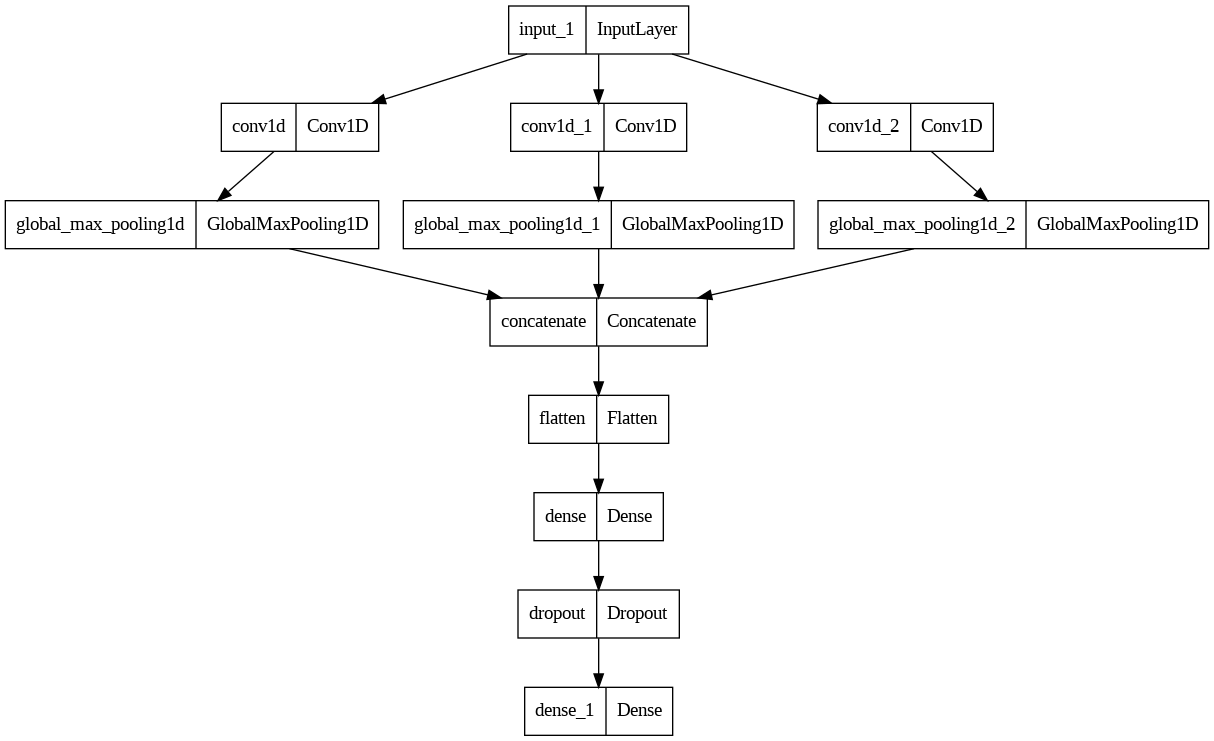

In [15]:
# Can show the graph of the model
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

-----

* `2. Using cosine similarity (as we did before)`

In [16]:
# Merge to get one vector for each document (n_docs, embed_size)
X_train_merged = np.mean(X_train_embed, axis=1)
X_test_merged = np.mean(X_test_embed, axis=1)

In [17]:
for i in random.choices(range(0, len(X_test_merged)), k=5):
    print(f"ID: {i}")
    print("True label:", colored(y_test[i], 'green'))
    distances = cosine_similarity(X_test_merged[i].reshape(1, EMBED_SIZE), X_train_merged).flatten()
    indices = np.argsort(distances)[::-1]
    for _, j in enumerate(indices[:3]):
        print(f"{_} nearest label is {colored(y_train[j], 'green' if y_train[j]==y_test[i] else 'red')}",
             f"similarity: {colored(round(distances[j], 3), 'yellow')}")

ID: 13
True label: rec.autos
0 nearest label is rec.autos similarity: 0.954
1 nearest label is rec.autos similarity: 0.954
2 nearest label is rec.autos similarity: 0.953
ID: 245
True label: comp.windows.x
0 nearest label is comp.windows.x similarity: 0.999
1 nearest label is comp.windows.x similarity: 0.851
2 nearest label is comp.windows.x similarity: 0.843
ID: 42
True label: soc.religion.christian
0 nearest label is soc.religion.christian similarity: 0.976
1 nearest label is soc.religion.christian similarity: 0.963
2 nearest label is soc.religion.christian similarity: 0.96
ID: 81
True label: rec.sport.baseball
0 nearest label is soc.religion.christian similarity: 0.969
1 nearest label is rec.autos similarity: 0.969
2 nearest label is rec.sport.baseball similarity: 0.967
ID: 187
True label: comp.windows.x
0 nearest label is comp.windows.x similarity: 1.0
1 nearest label is comp.windows.x similarity: 1.0
2 nearest label is comp.windows.x similarity: 0.976


In [18]:
# List to append in it the predicted of test labels
y_pred_test = []

# Loop over the entire test dataset
for i in range(len(X_test)):
    # Compute cosine similarity between the test instance and all training instances
    distances = cosine_similarity(X_test_merged[i].reshape(1, EMBED_SIZE), X_train_merged).flatten()
    # Get the indices of the training instances sorted by similarity in descending order
    indices = np.argsort(distances)[::-1]
    # Get the labels of the three nearest neighbors
    nearest_labels = [y_train[j] for j in indices[:3]]
    # Determine the most common label among the three nearest neighbors
    y_pred_each = Counter(nearest_labels).most_common(1)[0][0]
    # Append to list
    y_pred_test.append(y_pred_each)

# Get Accuracy score
acc = accuracy_score(y_test, y_pred_test)
print(f'Acccuray Score using cosine simlarity is: {acc*100:.3f} %') # using cosine similarity as a metric

Acccuray Score using cosine simlarity is: 74.528 %


---

* `3. Using Euclidean Distance for measuring similarity`

In [19]:
for i in random.choices(range(0, len(X_test)), k=5):
    print(f"ID: {i}")
    print("True label:", colored(y_test[i], 'green'))
    distances = euclidean_distances(X_test_merged[i].reshape(1, EMBED_SIZE), X_train_merged).flatten()
    indices = np.argsort(distances)
    for _, j in enumerate(indices[:3]):
        print(f"{_} nearest label is {colored(y_train[j], 'green' if y_train[j]==y_test[i] else 'red')}",
             f"similarity: {colored(round(distances[j], 3), 'yellow')}")

ID: 158
True label: comp.windows.x
0 nearest label is rec.autos similarity: 1.845
1 nearest label is comp.windows.x similarity: 1.856
2 nearest label is comp.windows.x similarity: 1.862
ID: 106
True label: rec.sport.baseball
0 nearest label is rec.sport.baseball similarity: 1.753
1 nearest label is rec.sport.baseball similarity: 1.789
2 nearest label is rec.sport.baseball similarity: 1.818
ID: 157
True label: soc.religion.christian
0 nearest label is soc.religion.christian similarity: 0.0
1 nearest label is soc.religion.christian similarity: 0.0
2 nearest label is rec.autos similarity: 0.0
ID: 248
True label: comp.windows.x
0 nearest label is comp.windows.x similarity: 1.683
1 nearest label is comp.windows.x similarity: 1.723
2 nearest label is comp.windows.x similarity: 1.723
ID: 64
True label: comp.windows.x
0 nearest label is comp.windows.x similarity: 2.401
1 nearest label is comp.windows.x similarity: 2.516
2 nearest label is comp.windows.x similarity: 2.653


In [20]:
# List to append in it the predicted of test labels
y_pred_test = []

# Loop over the entire test dataset
for i in range(len(X_test)):

    # Compute euclidean_distances between the test instance and all training instances
    distances = euclidean_distances(X_test_merged[i].reshape(1, EMBED_SIZE), X_train_merged).flatten()
    # Get the indices of the training instances sorted by distance in ascending order
    indices = np.argsort(distances)
    # Get the labels of the three nearest neighbors
    nearest_labels = [y_train[j] for j in indices[:3]]
    # Determine the most common label among the three nearest neighbors
    y_pred_each = Counter(nearest_labels).most_common(1)[0][0]
    # Append to list
    y_pred_test.append(y_pred_each)

# Get Accuracy score
acc = accuracy_score(y_test, y_pred_test)
print(f'Acccuray Score using Euclidean Distance is: {acc*100:.3f} %') # usign euclidean distance

Acccuray Score using Euclidean Distance is: 70.755 %


-----